# Stage 2: Cdc42 Cycle

### Create the pyURDME model and the solver object

In [1]:
%matplotlib inline
import pyurdme
import os
import dolfin
import mshr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy
import time
import sys
import scipy
import pickle

# Mesh Move function

In [2]:
def move_and_refine_mesh(inmesh, new_boundary, max_volume=0.2):
    tmp_mesh = dolfin.Mesh(inmesh)
    tmp_mesh.move(new_boundary)
    tmp_mesh.bounding_box_tree().build(tmp_mesh)  # Bounding box fix from Jan Blechta

    cell_markers = dolfin.CellFunction("bool", tmp_mesh)
    cell_markers.set_all(False)
    cell_cnt = 0
    refine_cnt = 0
    for c in dolfin.cells(tmp_mesh):
        cell_cnt+=1
        if c.volume() > max_volume:
            cell_markers[c] = True
            refine_cnt += 1
            #print c, c.volume()
    print "refining {0}/{1} cells".format(refine_cnt,cell_cnt)
    if refine_cnt > 0:
        return dolfin.mesh.refinement.refine(tmp_mesh, cell_markers)
    else:
        return tmp_mesh

In [3]:
def move_mesh_gaussian(inmesh, c=[0,0,0], scale=1.0, sigma=1.0):
    z_ndx = 0
    cords = [0,1,2]
    cords.remove(z_ndx)
    bmesh = dolfin.BoundaryMesh(inmesh, "exterior")
    for x in bmesh.coordinates():
        #print "x={0}".format(x),
        if x[z_ndx]-c[z_ndx] < 0:
            #print "z_move = scale*numpy.exp(-((x[{0}]**2)/2/sigma + (x[{1}]**2)/2/sigma)) ".format(cords[0],cords[1]),
            z_move = -1*scale*numpy.exp(-(((x[cords[0]]-c[cords[0]])**2)/2/sigma + ((x[cords[1]]-c[cords[1]])**2)/2/sigma))
            #print " z_move={0}".format(z_move),
            x[z_ndx] = x[z_ndx] + z_move
            #print " x={0}".format(x),
        #print " "
    return bmesh

In [4]:
# Calculate the normal vec at each vertex along the exterior of the mesh
def calculate_surface_normal_vec(model):
    vertex_normal_vec = numpy.zeros((model.mesh.num_vertices(),3))
    vertex_normal_cnt = numpy.zeros((model.mesh.num_vertices(),1))
    for fndx in range(model.mesh.num_facets()):
        facet = dolfin.Facet(model.mesh, fndx)
        if facet.exterior():
            nvec = numpy.array([facet.normal().x(), facet.normal().y(), facet.normal().z()])
            vndx_list = facet.entities(0)
            #print fndx, nvec, vndx_list
            for vndx in vndx_list:
                vertex_normal_vec[vndx,:] += nvec
                vertex_normal_cnt[vndx] += 1
    for vndx in range(vertex_normal_vec.shape[0]):
        if vertex_normal_cnt[vndx] > 0:
            norm_val = numpy.linalg.norm(vertex_normal_vec[vndx,:])
            if norm_val > 0:
                vertex_normal_vec[vndx,:] = vertex_normal_vec[vndx,:] / norm_val
            #print vndx, vertex_normal_vec[vndx,:], model.mesh.coordinates()[vndx,:]
    return vertex_normal_vec

In [5]:
def move_mesh_actin_normal(result, rate=1.0, actin_ndx='Actinm'):
    normal_vec_list = calculate_surface_normal_vec(result.model)
    Actin_factor = rate * numpy.sum(result.get_species(actin_ndx, concentration=False), axis=0) / (result.tspan[-1]-result.tspan[0]+1)
    bmesh = dolfin.BoundaryMesh(result.model.mesh, "exterior")
    for vndx, x in enumerate(bmesh.coordinates()):
        x += normal_vec_list[vndx,:]*Actin_factor[vndx]
    return bmesh

Adaptive stepping can be accomplished by setting a maximum value for the norm of the moving mesh.  Since the movement is linear in time, we can reduce the size of the distance moved by the mesh by reducing the lenght of time for the next step until the max constraint is satisfied.

In [6]:
def move_mesh_max_actin_gaussian_normal(result, rate=1.0, sigma=0.5, actin_ndx='Actinm', time_step_length=None):
    normal_vec_list = calculate_surface_normal_vec(result.model)
    #Actin_factor = rate * numpy.sum(result.get_species(actin_ndx, concentration=True), axis=0) / (result.tspan[-1]-result.tspan[0]+1)
    Actin = result.get_species(actin_ndx, concentration=False)
    if time_step_length is None:
        time_step_length = (result.tspan[-1]-result.tspan[0]+1)
    Actin_factor = rate * numpy.sum(Actin, axis=0) / Actin.shape[0] * time_step_length
    
    bmesh = dolfin.BoundaryMesh(result.model.mesh, "exterior")
    max_ndx = numpy.where(Actin_factor==Actin_factor.max())[0][0]
    max_coords = result.model.mesh.coordinates()[max_ndx]
    print "{0} is max voxel with {1}={2}  {3}".format(max_ndx,actin_ndx,Actin_factor.max(), max_coords)
    max_move_ndx=-1
    max_move_norm=-1
    for vndx, x in enumerate(bmesh.coordinates()):
        move_value = Actin_factor[max_ndx]*numpy.exp(-numpy.sum((x - max_coords)**2)/2/sigma)
        move_norm = numpy.linalg.norm(normal_vec_list[max_ndx,:]*move_value)
        if move_norm > max_move_norm:
            max_move_norm = move_norm
            max_move_ndx = vndx
        x += normal_vec_list[max_ndx,:]*move_value #move normal to the max value
    print "max_move_ndx={0}  max_move_norm={1}".format(max_move_ndx, max_move_norm)
    return bmesh

In [7]:
def move_mesh_max10pct_avg_actin_gaussian_normal(result, rate=1.0, sigma=0.5, actin_ndx='Actinm', time_step_length=None):
    normal_vec_list = calculate_surface_normal_vec(result.model)
    if time_step_length is None:
        time_step_length = (result.tspan[-1]-result.tspan[0]+1)
        
    max_ndx, avg_actin = index_and_average_value_of_max_10pct_region(result, species=actin_ndx)
    Actin_factor = rate * avg_actin * time_step_length
    
    bmesh = dolfin.BoundaryMesh(result.model.mesh, "exterior")
    max_coords = result.model.mesh.coordinates()[max_ndx]
    print "{0} is max voxel with max_move_norm={1} {2}".format(max_ndx,Actin_factor, max_coords)
    for vndx, x in enumerate(bmesh.coordinates()):
        move_value = Actin_factor*numpy.exp(-numpy.sum((x - max_coords)**2)/2/sigma)
        x += normal_vec_list[max_ndx,:]*move_value #move normal to the max value
    return bmesh

In [8]:
def save_moving_mesh_simulation(result_vec):
    for ndx in range(1000):
        fname = "{0}-moving_mesh_simulation-{1}.pkl".format(result_vec[0].model.name, ndx)
        if os.path.exists(fname):
            continue
        print "Saving dataset to '{0}'".format(fname)
        with open(fname, 'w+') as fd:
            pickle.dump(result_vec, fd)
        return

In [9]:
#This currently uses the voxels listed in voxels_center (which are the top "X" percent of particle counts in B_vals) and checks
#an area around the center equivalent to roughly 10% of the membrane surface area and calculates a percentage of membrane particles
#found for each one
def index_and_average_value_of_max_10pct_region(result, species=None):
    if species is None:
        raise Exception("percent_polarized_v_time(), please specify species")
    model = result.model
    data = model.get_solver_datastructure()
    sd = model.get_subdomain_vector()
    vol = data['vol']
    membrane_voxels = []
    for voxel_index, voxel_coords in enumerate(model.mesh.coordinates()):
        if sd[voxel_index] == 2:
            membrane_voxels.append(voxel_index)    
            
    #B_vals_list = result.get_species(species, timepoints=tndx, concentration=False)
    Actin = result.get_species(species, concentration=False)
    B_vals_list = numpy.sum(Actin, axis=0) / Actin.shape[0]
    
    B_vals_sort_list = sorted(B_vals_list)
    B_vals_to_check_list = B_vals_sort_list[int(len(B_vals_sort_list) * .98) : int(len(B_vals_sort_list) * 1.0)]
    min_to_check_list = min(B_vals_to_check_list)
    voxels_center_list = map(int,[i for i, j in enumerate(B_vals_list) if j >= min_to_check_list and sd[i] == 2])
        
    B_check = sum(B_vals_list)
    particle_sum_list = []
    percentage_around_center_list = []
    voxel_counter_list = []
    voxels_visited_list = []
    if B_check==0:
        percentage_around_center = 0
        percentage_around_center_list.append([percentage_around_center,0.0])
    else:
        j = 0
        for v in voxels_center_list:
            particle_sum = 0.0
            percentage_around_center = 0.0
            voxel_counter = 0.0
            voxels_visited = []
            x_center = model.mesh.coordinates()[v,0]
            y_center = model.mesh.coordinates()[v,1]
            z_center = model.mesh.coordinates()[v,2]
            dist_center = numpy.sqrt(x_center*x_center + y_center*y_center + z_center*z_center)
            for i in membrane_voxels: 
                x_check = model.mesh.coordinates()[i,0]
                y_check = model.mesh.coordinates()[i,1]
                z_check = model.mesh.coordinates()[i,2]
                dist_check = numpy.sqrt(x_check*x_check + y_check*y_check + z_check*z_check)
                angle_between = numpy.arccos(numpy.dot([x_center,y_center,z_center],[x_check,y_check,z_check])/(dist_check*dist_center) - 1e-8)
                if angle_between <= numpy.arcsin(.6):
                    particle_sum = particle_sum + B_vals_list[i]
                    voxel_counter = voxel_counter + 1
                    voxels_visited.append(i)

            particle_sum_list.append(particle_sum)
            voxel_counter_list.append(voxel_counter)
            voxels_visited_list.append([voxels_visited,v])

            percentage_around_center = particle_sum_list[j]/B_check*100 

            percentage_around_center_list.append([percentage_around_center,v, particle_sum/float(voxel_counter)])
            j = j + 1

    tmp = max(percentage_around_center_list)
    return tmp[1], tmp[2]# voxel_index, average_value_of_max_10pct_region

# Define Model

In [10]:
class Membrane(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

In [11]:
class GbgGradient(pyurdme.URDMEDataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0,mem_vol=1.0):
        """ 1D domain from a to b. """
        pyurdme.URDMEDataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope  # NM/um
        self.mem_vol = mem_vol
        
    def map(self, x):
        ret = self.Gbg_slope*-1*x[1] + self.Gbg_mid
        return ret/self.mem_vol

In [12]:
class Cdc42_cycle_3D(pyurdme.URDMEModel):

    def __init__(self, model_name="Cdc42_3D-Moving_Mesh",Gbg_conc=5000.0, Gbg_pct_slope=0.1,delta1_val=0.00297,delta1_gbg_val=0.00297,delta_neg_val=1.0/30000, end_time=None, mesh=None):
        pyurdme.URDMEModel.__init__(self,model_name)

        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 50.0          #not sure of bulk diffusion const
        
        # Species
        Cdc24_m= pyurdme.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
        Cdc24_c= pyurdme.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
        Cdc42= pyurdme.Species(name="Cdc42",  diffusion_constant=D_GDP)
        Cdc42_a= pyurdme.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
        Bem1_m = pyurdme.Species(name="Bem1_m",  diffusion_constant=D_membrane)
        Bem1_c = pyurdme.Species(name="Bem1_c",  diffusion_constant=D_bulk)
        Cla4 = pyurdme.Species(name="Cla4",  diffusion_constant=D_bulk)
        Cla4_a = pyurdme.Species(name="Cla4_a",  diffusion_constant=D_membrane)
        
        Cdc42_c = pyurdme.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
        #Gbg = pyurdme.Species(name="Gbg",  diffusion_constant=D_membrane)
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])#,Gbg])
        
#         L = 4*3.14159
#         NUM_VOXEL = 200
#         MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
        #Define Geometry
        cell_radius = 2.0
        sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), cell_radius)
        if mesh is not None:
            self.mesh = pyurdme.URDMEMesh(mesh=mesh)
        else:
            self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 15)) #12 works pretty similar, question of correction like in polarisome
        
        cell_function = dolfin.CellFunction("size_t",self.mesh)
        cell_function.set_all(1)
        
        facet_function = dolfin.FacetFunction("size_t",self.mesh)
        facet_function.set_all(0)
        
        membrane = Membrane()
        membrane.mark(facet_function,2)
        
        self.add_subdomain(cell_function)
        self.add_subdomain(facet_function)
        
        data = self.get_solver_datastructure()
        sd = self.get_subdomain_vector()
        volume_vector = data['vol']
        
        membrane_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if sd[voxel_index] == 2:
                    membrane_volume = membrane_volume + volume_vector[voxel_index]
                    
        cytoplasm_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if sd[voxel_index] == 1:
                    cytoplasm_volume = cytoplasm_volume + volume_vector[voxel_index]
        
#         SA    = pyurdme.Parameter(name="SA" ,expression=50.265)
#         V     = pyurdme.Parameter(name="V" ,expression=33.5)
        k_42d =   pyurdme.Parameter(name="k_42d", expression=1.0)#0.02)
        k_42a =   pyurdme.Parameter(name="k_42a", expression=0.2)#1e-05*membrane_volume)#*SA)
        #k_24cm0 = pyurdme.Parameter(name="k_24cm0", expression=0.04*cytoplasm_volume)#*V/SA)
        k_24cm1 = pyurdme.Parameter(name="k_24cm1", expression=delta1_val)#3.3e-03*cytoplasm_volume)#*V)
        k_24mc =  pyurdme.Parameter(name="k_24mc", expression=0.35)#1.0)
        k_B1mc =  pyurdme.Parameter(name="k_B1mc", expression=0.35)#0.01)
        k_B1cm =  pyurdme.Parameter(name="k_B1cm", expression=0.2667)#1e-05*cytoplasm_volume)#*V)
        k_Cla4a = pyurdme.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = pyurdme.Parameter(name="k_Cla4d", expression=0.01)
        k_24d =   pyurdme.Parameter(name="k_24d", expression=delta_neg_val)#1/3000#membrane_volume#SA
        
        beta1 = pyurdme.Parameter(name="beta1", expression=0.266)
        beta2 = pyurdme.Parameter(name="beta2", expression=0.28)
        beta3 = pyurdme.Parameter(name="beta3", expression=1.0)
        delta1_gbg = pyurdme.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

        # Add Data Function to model the mating pheromone gradient.
        #self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=(1000.0/4.0),mem_vol=membrane_volume))
        self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=Gbg_conc*Gbg_pct_slope/(cell_radius*2.0),mem_vol=membrane_volume))

        # Reactions
        # Reactions
        #Gbg as species
        #CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1,Gbg:1}, products={Cdc24_m:1,Gbg:1}, rate=delta1,restrict_to=2)#propensity_function="0.00297*Cdc24_c*GbgGradient*vol", restrict_to=2)
        #Gbg as input function
        #DIFFERENCE WHETHER TO MULTIPLY BY 32 OR NOT
        CR0 = pyurdme.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
        CR1 = pyurdme.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
        CR2 = pyurdme.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
        CR3 = pyurdme.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
        CR4 = pyurdme.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
        CR5 = pyurdme.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
        CR6 = pyurdme.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
        CR7 = pyurdme.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
        CR8 = pyurdme.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
        CR9 = pyurdme.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
        CR10 = pyurdme.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
        CR11 = pyurdme.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
        CR12 = pyurdme.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
        self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
        #self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9])
        
        self.restrict(species=Cdc24_c,subdomains=[1,2])
        self.restrict(species=Bem1_c,subdomains=[1,2])
        self.restrict(species=Cla4,subdomains=[1,2])
        self.restrict(species=Cdc24_m,subdomains=[2])
        self.restrict(species=Cdc42,subdomains=[2])
        self.restrict(species=Cdc42_a,subdomains=[2])
        self.restrict(species=Bem1_m,subdomains=[2])
        self.restrict(species=Cla4_a,subdomains=[2])
        self.restrict(species=Cdc42_c,subdomains=[1,2])
        #self.restrict(species=Gbg,subdomains=[2])
        
        
        # Distribute molecules randomly over the mesh according to their initial values
        self.set_initial_condition_scatter({Cdc42:2700},[2]) #10000  
        self.set_initial_condition_scatter({Cdc24_c:1000},[1])    #We have 2000 Cdc24, GDI model has 1000
        self.set_initial_condition_scatter({Bem1_c:3000},[1])
        self.set_initial_condition_scatter({Cla4:5000},[1]) #5000
        #self.set_initial_condition_scatter({Cdc42_c:1500},[1])
        self.set_initial_condition_scatter({Cdc42_a:300},[2])
        #self.set_initial_condition_scatter({Gbg:5000},[2])
        
        if end_time is None:
            self.timespan(range(1000))
        else:
            self.timespan([0, end_time])
            print "simulating to {0}s".format(end_time)

In [13]:
model = Cdc42_cycle_3D(end_time=1)

simulating to 1s


In [14]:
result = model.run()

In [16]:
#model.mesh

# Mesh Moving simulations

In [17]:
if result_vec[0] is not None: result_vec_1st_step = result_vec[0]

NameError: name 'result_vec' is not defined

In [21]:
result_vec = [None]*20

In [20]:
result_vec[0] = result_vec_1st_step

NameError: name 'result_vec_1st_step' is not defined

In [22]:
tsplit=20; V_max=5e-4; sigma=0.25
print "Running moving mesh simulation with tsplit={0}, V_max={1}, sigma={2}".format(tsplit, V_max, sigma)
max_volume=0.0;save_results = False
for split_ndx in range(len(result_vec)):
    sys.stdout.flush()
    if split_ndx==1:
        # get max voxel volume
        for c in dolfin.cells(result_vec[split_ndx-1].model.mesh):
            if c.volume() > max_volume: max_volume = c.volume()
        print "max_volume={0}".format(max_volume)
    if result_vec[split_ndx] is not None:
        print "Using previously calucated result for step {0}".format(split_ndx)
    elif split_ndx == 0:
        print "Creating model for step {0}".format(split_ndx)
        # Create model
        tic = time.time()
        model = Cdc42_cycle_3D(end_time=500)
        # Run simulation
        result_vec[split_ndx] = model.run()
        print time.time() - tic,'s'
    else:
        save_results=True
        step_length = tsplit
        step_time_computed = 0
        while step_time_computed < tsplit:
            tic = time.time()
            try:
                print "Moving mesh and simulating step {0} for {1}s".format(split_ndx, step_length)
                # calculate new mesh based on previous result
                movement_vec = move_mesh_max10pct_avg_actin_gaussian_normal(result_vec[split_ndx-1], time_step_length=step_length, rate=V_max, sigma=sigma, actin_ndx='Cdc42_a')
                #movement_vec = move_mesh_max_actin_gaussian_normal(result_vec[split_ndx-1], time_step_length=step_length, rate=V_max, sigma=0.01, actin_ndx='Cdc42_a')
                #movement_vec = move_mesh_actin_normal(result_vec[split_ndx-1], rate=0.1, actin_ndx='Actinm')
                mesh = move_and_refine_mesh(result_vec[split_ndx-1].model.mesh, movement_vec, max_volume=max_volume)
                # Create model and transfer simulation state
                model = Cdc42_cycle_3D(mesh=mesh, end_time=step_length)
                model.set_initial_condition_from_result_different_mesh(result_vec[split_ndx-1])
                # Run simulation
                result_vec[split_ndx] = model.run()
                step_time_computed += step_length
            except pyurdme.InvalidSystemMatrixException as e:
                sys.stderr.write("{0}".format(e))
                sys.stderr.flush()
                step_length = step_length / 2.0
            print time.time() - tic,'s'
        #raise Exception("Stopping after one computation")
        
if save_results: save_moving_mesh_simulation(result_vec)

Running moving mesh simulation with tsplit=20, V_max=0.0005, sigma=0.25
Creating model for step 0
simulating to 500s
1052.03394008 s
max_volume=0.00898735930223
Moving mesh and simulating step 1 for 20s
573 is max voxel with max_move_norm=0.227410714286 [ 0.61041592 -1.71811021 -0.79280938]
refining 3/7708 cells
simulating to 20s
98.7191441059 s


Exception: Stopping after one computation

In [13]:
#with open('Cdc42_3D-Moving_Mesh-moving_mesh_simulation-13.pkl') as fd:
#    result_vec2 = pickle.load(fd)

In [38]:
#result_vec2[0].display('Cdc42_a', -1,camera=[-1.38,-1.58,0.05], width=750)

In [34]:
#result_vec2[0].model.mesh.display(camera=[-1.38,-1.58,0.05], width=750)

In [35]:
#result_vec2[5].model.mesh.display(camera=[-1.38,-1.58,0.05], width=750)

In [37]:
#result_vec2[5].display('Cdc42_a', -1, camera=[-1.38,-1.58,0.05], width=750)

In [14]:
def max_vec(result, species='Cdc42_a'):
    max_ndx, avg_actin = index_and_average_value_of_max_10pct_region(result, species=species)
    max_vec_val = result.model.mesh.coordinates()[max_ndx,:]
    return max_vec_val

In [15]:
def plot_2D_cell_profile_v2(result, species='Cdc42_a'):
    max_ndx, avg_actin = index_and_average_value_of_max_10pct_region(result, species=species)
    model = result.model
    max_vec = model.mesh.coordinates()[max_ndx,:]
    random_vec = [1.0,0.0,0.0]  #radom vector (can't be linearly dependent on max) to create plane 
    normal_vec = numpy.cross(max_vec,random_vec)
    num_voxels = model.mesh.coordinates().shape[0]
    ret_vec = numpy.zeros((num_voxels,2))
    for i in range(num_voxels):
        check_vec = model.mesh.coordinates()[i,:]
        #dist_to_plane = numpy.abs(numpy.dot(normal_vec,check_vec)/numpy.linalg.norm(check_vec)
        dist_to_plane = numpy.dot(normal_vec,check_vec)/numpy.dot(normal_vec, normal_vec)
        
        check_vec_proj = check_vec - normal_vec*dist_to_plane
        
        dist_to_plane_proj = numpy.abs(numpy.dot(normal_vec,check_vec_proj))
        
        #print 'for i={0}, dist_to_plane_proj={1}, dist_to_plane={2}'.format(i, dist_to_plane_proj, dist_to_plane)
        #if dist_to_plane_proj > dist_to_plane:
        #    check_vec_proj = check_vec + normal_vec*dist_to_plane/numpy.linalg.norm(normal_vec)
        
        max_vec_norm = max_vec / numpy.linalg.norm(max_vec)
        normal_vec_norm = normal_vec / numpy.linalg.norm(normal_vec)
        
        rand_vec_norm = numpy.cross(normal_vec_norm, max_vec_norm)
        
        A = numpy.zeros((3,3))
        A[:,0] = max_vec_norm
        A[:,1] = rand_vec_norm
        A[:,2] = normal_vec_norm
        
        c = numpy.linalg.solve(A, check_vec_proj)
        ret_vec[i,0] = c[0]
        ret_vec[i,1] = c[1]
        if numpy.abs(c[2]) > 1e-15:
            print 'c[2]', c[2]
            print 'A',A
            print 'check_vec_proj', check_vec_proj
            raise Exception('c[2] not zero')
        
#         x_proj = numpy.dot(check_vec_proj, max_vec/numpy.linalg.norm(max_vec))
#         ##y_proj = numpy.sqrt( numpy.linalg.norm(check_vec_proj)**2 - x_proj**2 )
#         ret_vec[i,0] = x_proj
#         ret_vec[i,1] = dist_to_plane
    return ret_vec

(-2.0, 4.0, -2.0, 2.0)

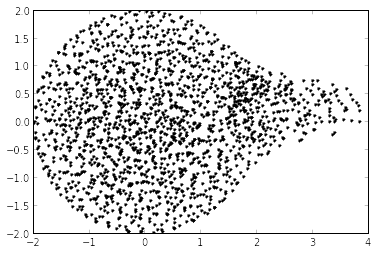

In [17]:
plot_data = plot_2D_cell_profile_v2(result_vec2[-1]) 
plt.plot(plot_data[:,0], plot_data[:,1],'.', color='#000000')
plt.axis('equal')


(-5.0, 40.0, -5.0, 30.0)

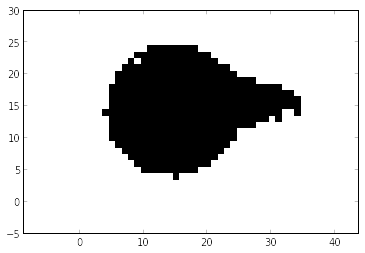

In [18]:
dh = 0.2
numX = 60
numY = 40
(minx, maxx) = (min(plot_data[:,0])-1,max(plot_data[:,0])+1)
(miny, maxy) = (min(plot_data[:,1])-1,max(plot_data[:,1])+1)
arrX = numpy.arange(minx,maxx,dh)
arrY = numpy.arange(miny,maxy,dh)
h,_,_ = numpy.histogram2d(plot_data[:,0],plot_data[:,1],bins=[arrX,arrY])
G = numpy.zeros(h.shape)
G[h>0] = 1
plt.imshow(G.T, cmap='Greys',  interpolation='nearest', aspect='equal', origin='lower')
plt.axis('equal')

In [23]:
import scipy.ndimage

(-10.0, 60.0, -5.0, 40.0)

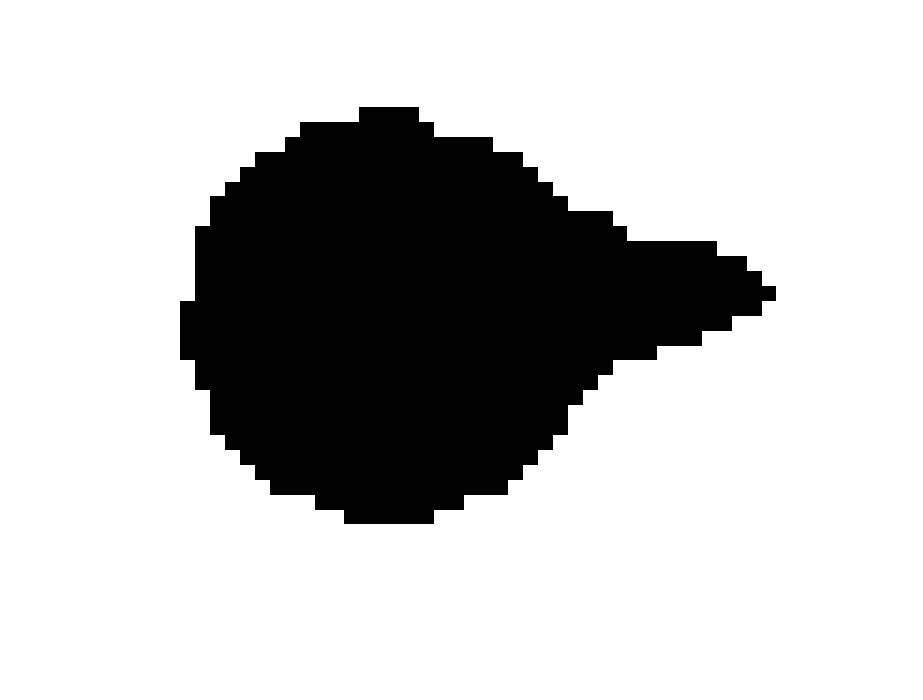

In [44]:
fig = plt.figure(figsize=(16,12), frameon=False);
dh = 0.15
numX = 60
numY = 40
(minx, maxx) = (min(plot_data[:,0])-1,max(plot_data[:,0])+1)
(miny, maxy) = (min(plot_data[:,1])-1,max(plot_data[:,1])+1)
arrX = numpy.arange(minx,maxx,dh)
arrY = numpy.arange(miny,maxy,dh)
h,_,_ = numpy.histogram2d(plot_data[:,0],plot_data[:,1],bins=[arrX,arrY])
G = numpy.zeros(h.shape)
G[h>0] = 1
G2 = scipy.ndimage.filters.gaussian_filter(G, sigma=1.1)
G3 = numpy.zeros(h.shape)
G3[G2>0.5] = 1
#plt.subplot(1,2,1)
plt.imshow(G3.T, cmap='Greys',  interpolation='nearest', aspect='equal', origin='lower')
plt.axis('equal')
plt.axis('off')
#plt.subplot(1,2,2)
#plt.imshow(G.T, cmap='Greys',  interpolation='nearest', aspect='equal', origin='lower')
#plt.axis('equal')
#plt.axis('off')


In [18]:
#import scipy.spatial

In [19]:
#hull = scipy.spatial.ConvexHull(plot_data)

In [19]:
#plt.plot(plot_data[hull.vertices,0], plot_data[hull.vertices,1], 'r--', lw=2)
#plt.plot(plot_data[[hull.vertices[-1],hull.vertices[0]],0], plot_data[[hull.vertices[-1],hull.vertices[0]],1], 'r--', lw=2)

In [46]:
all_plot_data = []
for n in range(len(result_vec2)):
    all_plot_data.append(plot_2D_cell_profile_v2(result_vec2[n]))

In [19]:
len(all_plot_data)

20

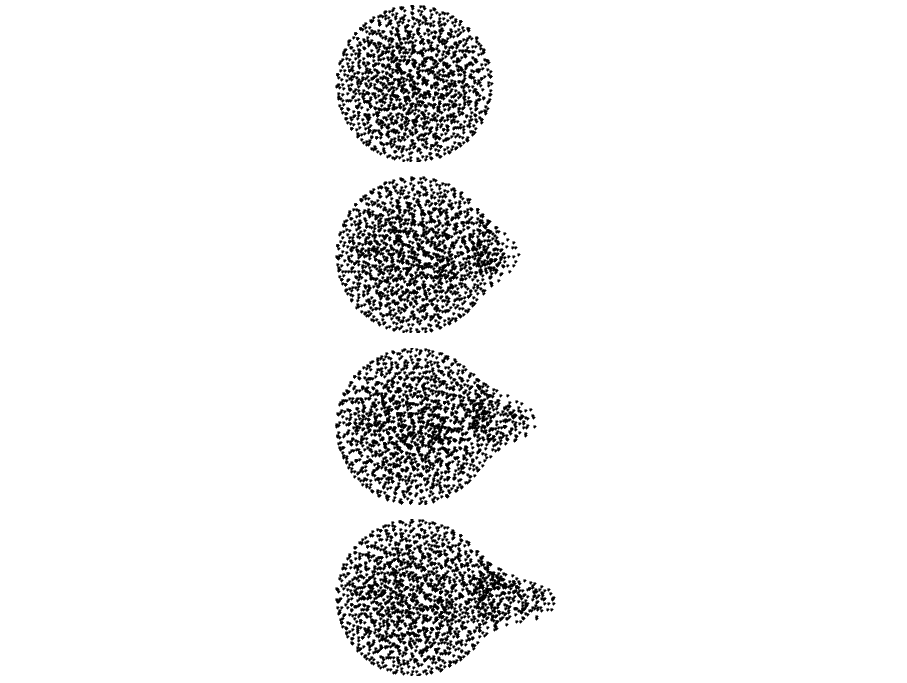

In [70]:
import matplotlib.gridspec as gridspec
(minx,maxx) = (min(all_plot_data[-1][:,0]),max(all_plot_data[-1][:,0]))
(miny,maxy) = (min(all_plot_data[-1][:,1]),max(all_plot_data[-1][:,1]))
fig = plt.figure(figsize=(16,12), frameon=False);
gs1 = gridspec.GridSpec(4, 1, wspace=0,hspace=0.1)
for n,i in enumerate([0,5,10,15]):
    ax = fig.add_subplot(gs1[n])
    plot_data = all_plot_data[i]
    ax.plot(plot_data[:,0], plot_data[:,1],'.', color='#000000')
    ax.plot((minx,maxx), (miny,maxy), '.',color='#ffffff')
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')



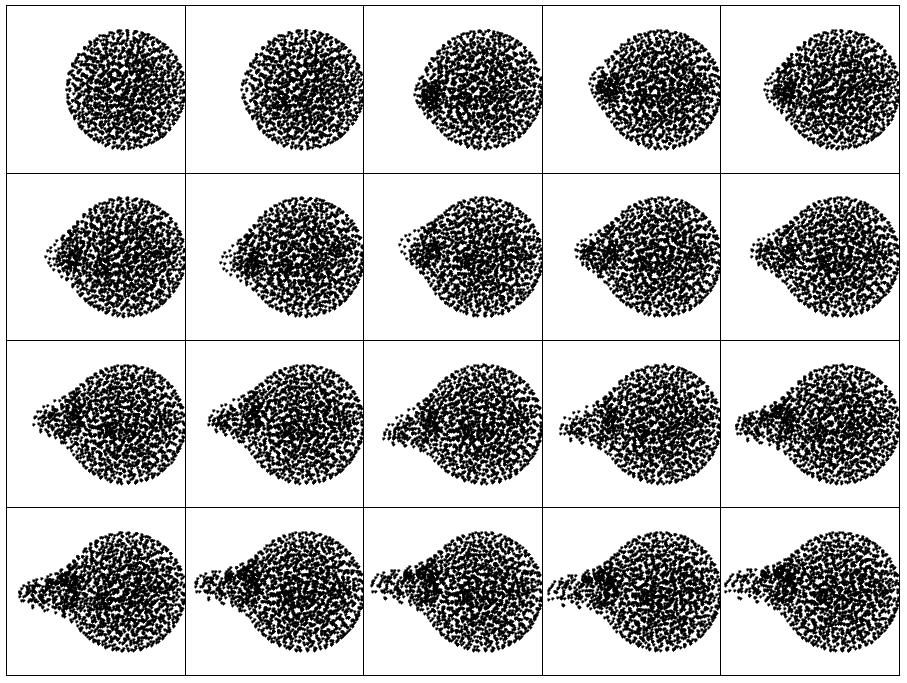

In [47]:
import matplotlib.gridspec as gridspec
(minx,maxx) = (min(all_plot_data[-1][:,0]),max(all_plot_data[-1][:,0]))
(miny,maxy) = (min(all_plot_data[-1][:,1]),max(all_plot_data[-1][:,1]))
fig = plt.figure(figsize=(16,12));
gs1 = gridspec.GridSpec(4, 5, wspace=0,hspace=0)
for n in range(len(result_vec2)):
    ax = fig.add_subplot(gs1[n])
    plot_data = all_plot_data[n]
    ax.plot(-1*plot_data[:,0], plot_data[:,1],'.', color='#000000')
    ax.plot((-1*minx,-1*maxx), (miny,maxy), '.',color='#ffffff')
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


In [59]:
max_vec(result_vec2[5])

array([ 1.36188946, -2.30405968, -0.16015254])

In [56]:
#result_vec2[0].display('Cdc42_a',-1, camera=[-0.82,-2.507,0.0829])

In [52]:
#result_vec2[5].display('Cdc42_a',-1, camera=[-0.82,-2.507,0.0829])

In [53]:
#result_vec2[10].display('Cdc42_a',-1, camera=[-0.82,-2.507,0.0829])

In [58]:
#result_vec2[15].display('Cdc42_a',-1, camera=[-0.82,-2.507,0.0829])

(-2.0, 2.0, -4.0, 2.0)

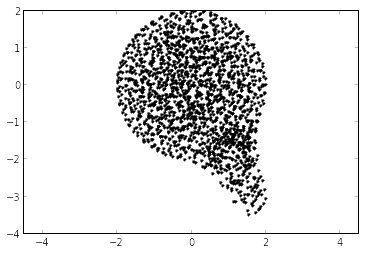

In [51]:
plot_ndx=-1
plt.plot(result_vec2[plot_ndx].model.mesh.coordinates()[:,0], result_vec2[plot_ndx].model.mesh.coordinates()[:,1], '.', color='#000000')
plt.axis('equal')

In [48]:
#result_vec2[-1].display('Cdc42_a',-1, camera=[0.9,-3,-0.1])

In [17]:
#result_vec[-1].display('Cdc42_a',-1)

In [62]:
#result_vec[1].display('Cdc42_a',0)

In [32]:
#result_vec[2].display('Cdc42_a',0)

In [31]:
#result_vec[3].display('Cdc42_a',0)

In [29]:
#result_vec[4].display('Cdc42_a',0)

In [69]:
#result_vec[5].display('Cdc42_a',0)

In [39]:
#result_vec[6].display('Cdc42_a',0)

In [41]:
#result_vec[7].display('Cdc42_a',0)

In [43]:
#result_vec[8].display('Cdc42_a',0)

In [68]:
#result_vec[9].display('Cdc42_a',0)

In [61]:
# def plot_2D_cell_profile(result, species='Cdc42_a'):
#     max_ndx, avg_actin = index_and_average_value_of_max_10pct_region(result, species=species)
#     model = result.model
#     max_vec = model.mesh.coordinates()[max_ndx,:]
#     random_vec = [1.0,0.0,0.0]  #radom vector (can't be linearly dependent on max) to create plane 
#     normal_vec = numpy.cross(max_vec,random_vec)
#     num_voxels = model.mesh.coordinates().shape[0]
#     ret_vec = numpy.zeros((num_voxels,2))
#     for i in range(num_voxels):
#         check_vec = model.mesh.coordinates()[i,:]
#         dist_to_plane = numpy.abs(numpy.dot(normal_vec,check_vec))/numpy.linalg.norm(check_vec)
#         check_vec_proj = check_vec - normal_vec*dist_to_plane/numpy.linalg.norm(normal_vec)
#         dist_to_plane_proj = numpy.abs(numpy.dot(normal_vec,check_vec_proj))/numpy.linalg.norm(check_vec)
#         if dist_to_plane_proj > dist_to_plane:
#             check_vec_proj = check_vec + normal_vec*dist_to_plane/numpy.linalg.norm(normal_vec)
            
#         x_proj = numpy.dot(check_vec_proj, max_vec/numpy.linalg.norm(max_vec))
#         #y_proj = numpy.sqrt( numpy.linalg.norm(check_vec_proj)**2 - x_proj**2 )
#         ret_vec[i,0] = x_proj
#         if dist_to_plane_proj > dist_to_plane:
#             ret_vec[i,1] = dist_to_plane
#         else:
#             ret_vec[i,1] = -1*dist_to_plane
#     return ret_vec